Iter 0: Loss = 1.07679930
Iter 0: Gradient = 4.77123963
||A(x)-y||_2 = 0.7329671515841208
data_term = 1.074481690602679
tv_term = 0.0023176134419875673
||grad_data|| = 4.771312733998581
||grad_tv|| = 0.0867790014106692
grad min/max: -0.07719256406019476 0.0034177304961340617
Iter 50: Loss = 0.01009481
Iter 50: Gradient = 0.00232062
||A(x)-y||_2 = 0.03820058864297483
data_term = 0.0029185699453395547
tv_term = 0.007176241829346334
||grad_data|| = 0.1463898643029626
||grad_tv|| = 14.640800800792627
grad min/max: -2.81806070065874e-05 2.5885465563511747e-05
Iter 100: Loss = 0.01008134
Iter 100: Gradient = 0.00119514
||A(x)-y||_2 = 0.03820052845977163
data_term = 0.0029185607492116443
tv_term = 0.0071627785522473085
||grad_data|| = 0.14638992938761458
||grad_tv|| = 14.639482436651416
grad min/max: -1.3343463086668768e-05 1.2559997721689898e-05
Iter 150: Loss = 0.01007632
Iter 150: Gradient = 0.00086231
||A(x)-y||_2 = 0.038200578538688246
data_term = 0.002918568401380978
tv_term = 0.0071577

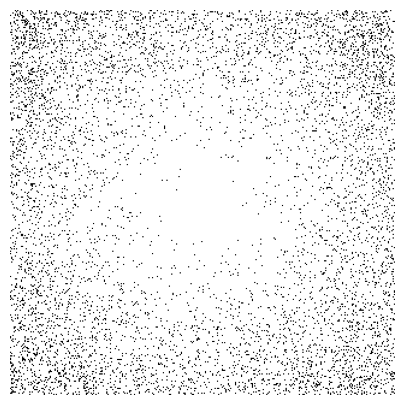

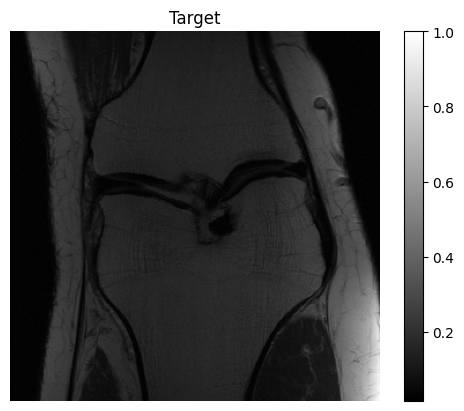

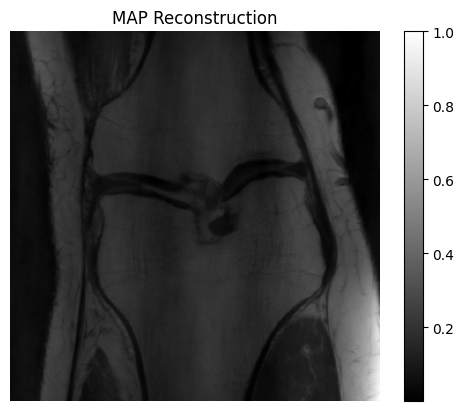

PSNR MAP: 33.10 dB
None


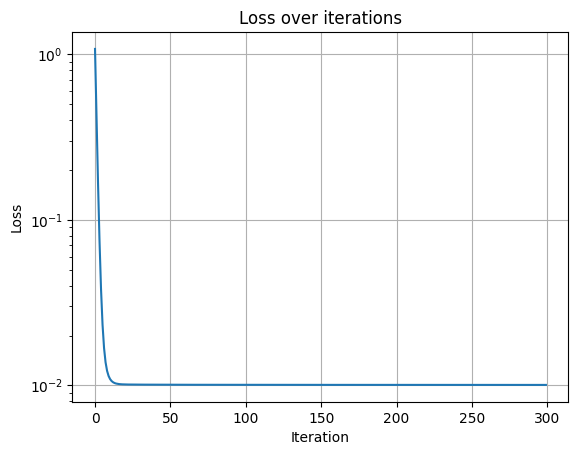

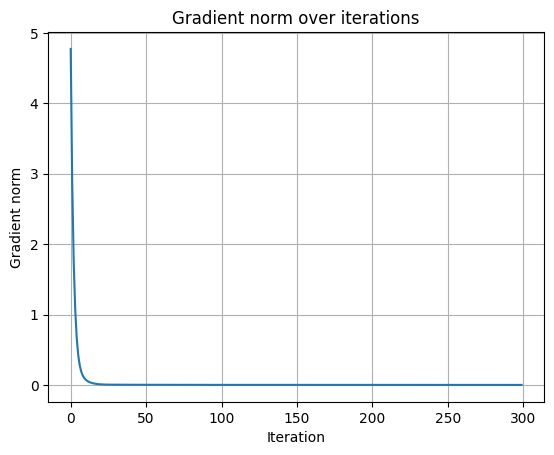

In [1]:
# MAP diagnostisc

import os
import sys
import fastmri
import fastmri.data
import fastmri.data.transforms
import h5py
import torch

# Set the path to the root of your project
project_root = os.path.abspath(os.path.join(os.getcwd(), r"C:\Users\kostanjsek\bachelor_project"))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
from utilities.masks import (
    CenteredBernoulliMask,
    UniformColumnMask,
    VariableDensityMask,
    PseudoRandomColumnMask,
    RadialMask
)
from fastmri.data import transforms as T
from utilities.metrics import psnr
from MAP.map_tv_minimize import MAPEstimator
from fastmri.data.mri_data import SliceDataset
from data.load_knee_mri import load_fastmri_data
from MMSE.mmse_ula import MMSEEstimatorULA
from MMSE.mmse_mala import MMSEEstimatorMALA
import skimage as ski


train_dataset, val_dataset, test_dataset = load_fastmri_data(
    r"C:\Users\kostanjsek\Documents\knee_mri"
)

file_name = r"C:\Users\kostanjsek\Documents\knee_mri\knee_singlecoil_train\singlecoil_train/file1000662.h5"
hf = h5py.File(file_name)

volume_kspace = hf['kspace'][()]
target = hf['reconstruction_rss'][()]

slice_kspace = volume_kspace[20]
slice_target = target[20]  # match slice index to kspace slice
tensor_kspace = T.to_tensor(slice_kspace)


mask = VariableDensityMask('gaussian', 1.5, seed=30).generate(slice_target.shape)
#mask = PseudoRandomColumnMask(slice_target.shape, 2, 1, seed=30).get_mask()
#mask = CenteredBernoulliMask(0.75, 0.25, seed=30).generate(slice_target.shape)

y = mask * np.fft.fft2(slice_target) # mask * slice_kspace
y = y / np.abs(y).max()

map_estimator = MAPEstimator(mask, 0.5, 0.01, 1e-2) # def-> 0.95, 0.01, 1e-2, 0.1, 100)
map_reconstruct = map_estimator.subgradient_descent(y)

# mask
plt.figure(figsize=(5, 5))
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
#plt.title('Pseudo random (Gaussian 1D)')
plt.axis('off')
plt.show()

# target
plt.imshow(slice_target / slice_target.max(), cmap="gray")
plt.title("Target")
plt.colorbar()
plt.axis("off")
plt.show()

# map reconstruct
plt.imshow(np.abs(map_reconstruct) / np.abs(map_reconstruct.max()) , cmap="gray")
plt.title("MAP Reconstruction")
plt.colorbar()
plt.axis("off")
plt.show()

# psnr
psnr_map = psnr(map_reconstruct, slice_target)
print(print(f"PSNR MAP: {psnr_map:.2f} dB"))

# loss
plt.plot(map_estimator.loss_history)
plt.title("Loss over iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.yscale('log')
plt.show()

# gradient
plt.plot(map_estimator.grad_norm_history)
plt.title("Gradient norm over iterations")
plt.xlabel("Iteration")
plt.ylabel("Gradient norm")
plt.grid(True)
#plt.yscale('log')
plt.show()

